In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import *
from tensorflow.keras.datasets import fashion_mnist

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

### Hyperparameters
#### Epoch: 100
#### Initial Learning Rate: 0.005
##### 測試過0.01太大，0.001有點小，取0.005。
#### Batch  Size: 512
##### 取2的次方數能加快學習，反正Colab的Ram不用白不用，就取了512。
#### Kernel Initializer: he_normal


In [0]:
epoch = 100
learning_rate = 5e-3
batch = 512
initializer = initializers.he_normal(seed=114)

### 定義basic_layer :
#### 順序是 Conv - BN - Dropout (- Maxpool) - Activation Function
###### -   卷積層都採用 3x3 Filter，stride=1，padding=1
###### -   每層都使用BN
###### -   Dropout策略使用Spatial Dropout代替基本Dropout
###### -   Maxpool使用(3,2,1)而非(2,2,0)
###### -   Activation Function使用ELUs
###### -   MP層放Activation層前面

In [0]:
def basic_layer(x, channel, dropoutrate = 0.0, bn = True, mp = False):
    x = layers.Conv2D(channel, (3, 3), padding='same', kernel_initializer=initializer)(x)
    if bn:
        x = layers.BatchNormalization()(x)
    if(dropoutrate>0):
        x = layers.SpatialDropout2D(dropoutrate)(x)
    if mp:
        x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.Activation('elu')(x)
    return x

In [0]:
def residual_layer(x, channel, dropoutrate = 0.0, bn = True, mp = False):
  x = basic_layer(x, channel, dropoutrate, bn, mp)
  x = basic_layer(x, channel, dropoutrate, bn, mp)
  return x

### 定義 residual_block :
#### residual = x
#### x = basic_layer(basic_layer(x))
#### residual_block = x + residual

In [0]:
def residual_block(x, channel, dropoutrate = 0.0, bn = True, mp = False):
  x = layers.add([x, residual_layer(x, channel, dropoutrate, bn, mp)])
  return x

###網路結構 :
#### 使用9層ResNet
#### channel : (16) - (32) - (Maxpool) - (Res_Block(32)) - (64) - (Maxpool) - (128) - (Res_Block(128)) - GAP - output
##### 用GAP代替FC層，效果好，節省運算資源

In [0]:
def resnet9(width, height, channel, classes, init_channel=16):
  inpt = Input(shape=(width, height, channel))
  x = basic_layer(inpt, init_channel)
  x = basic_layer(x, init_channel*2, dropoutrate = 0.125, mp = True)
  x = residual_block(x, init_channel*2, dropoutrate = 0.125)
  x = basic_layer(x, init_channel*4, dropoutrate = 0.25, mp = True)
  x = basic_layer(x, init_channel*8, dropoutrate = 0.25)
  x = residual_block(x, init_channel*8, dropoutrate = 0.25)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(classes, activation='softmax')(x)

  model = Model(inputs=inpt, outputs=x)
  return model

In [0]:
model = resnet9(28,28,1,10)

#### Optimizer : Adam
#### Train : Validation : Test = 5 : 1 : 1

In [0]:
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2)
history = model.fit(x_train,
                    y_train, 
                    batch_size=batch, 
                    epochs=epoch, 
                    verbose = 2,
                    validation_split = (1/6),
                    callbacks=[early_stop]
                    )  

Epoch 1/100
98/98 - 4s - loss: 0.8447 - accuracy: 0.6864 - val_loss: 2.5409 - val_accuracy: 0.5405
Epoch 2/100
98/98 - 3s - loss: 0.5351 - accuracy: 0.8038 - val_loss: 0.6567 - val_accuracy: 0.7587
Epoch 3/100
98/98 - 3s - loss: 0.4284 - accuracy: 0.8426 - val_loss: 0.4666 - val_accuracy: 0.8221
Epoch 4/100
98/98 - 3s - loss: 0.3696 - accuracy: 0.8656 - val_loss: 0.3550 - val_accuracy: 0.8718
Epoch 5/100
98/98 - 3s - loss: 0.3291 - accuracy: 0.8815 - val_loss: 0.3378 - val_accuracy: 0.8867
Epoch 6/100
98/98 - 3s - loss: 0.3027 - accuracy: 0.8916 - val_loss: 0.2634 - val_accuracy: 0.9066
Epoch 7/100
98/98 - 3s - loss: 0.2909 - accuracy: 0.8958 - val_loss: 0.3080 - val_accuracy: 0.8923
Epoch 8/100
98/98 - 3s - loss: 0.2791 - accuracy: 0.8994 - val_loss: 0.2664 - val_accuracy: 0.9085
Epoch 9/100
98/98 - 3s - loss: 0.2609 - accuracy: 0.9067 - val_loss: 0.3024 - val_accuracy: 0.8948
Epoch 10/100
98/98 - 3s - loss: 0.2546 - accuracy: 0.9081 - val_loss: 0.2638 - val_accuracy: 0.9101
Epoch 11/

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.2508 - accuracy: 0.9291


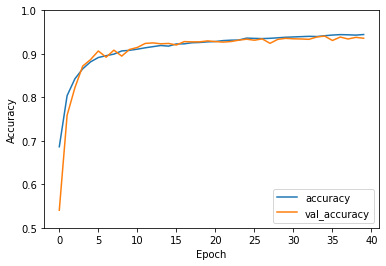

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# plt.savefig("ann_acc.png", dpi=500)

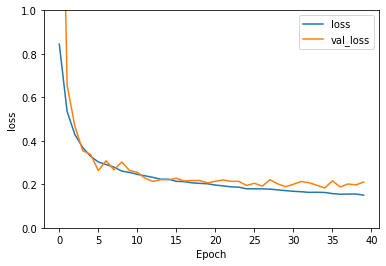

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
# plt.savefig("ann_loss.png", dpi=500)

##Result : 
### Train accuracy: 94.44%
### Valid accuracy: 93.59%
### Test  accuracy: 92.91%
#### Early_stopping讓模型在第40個epoch就停止訓練
